# Exercise 1

In [65]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import requests
import re
import matplotlib
%matplotlib inline
from enum import Enum
from bs4 import BeautifulSoup

The data can be fetched from IS-Academia usign a form. To automate this process we looked at the form  source code to find out what query is sent to the server to obtain the data. We found that the query is sent to http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter with the values of the form fields as request parameters (appended to the URL after a '?').

The first step is to find out the values correspondig to the parameters we're interested in. To do so we parse the form HTML with BeautifulSoup.

In [ ]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=2016-2017&ww_x_PERIODE_ACAD=355925344&zz_x_PERIODE_PEDAGO=Bachelor+semestre+1&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=&ww_x_HIVERETE=null&dummy=ok')
soup = BeautifulSoup(r.text, 'html.parser')

In [ ]:
def printFieldValues(field_name):
    for opt in soup.find('select', {'name': field_name}).find_all('option'):
        print(opt.string, "=", opt['value'])

The values of the different fields:

In [ ]:
# Academic unit
print("=== Academic unit ===")
printFieldValues('ww_x_UNITE_ACAD')

# Academic period
print("\n\n=== Academic period ===")
printFieldValues('ww_x_PERIODE_ACAD')

# Pedagogic period
print("\n\n=== Pedagogic period ===")
printFieldValues('ww_x_PERIODE_PEDAGO')

To make the code more readable we define enums containing these values:

In [ ]:
# Define ISA codes

class AcademicUnit(Enum):
    Informatique = 249847
    
class AcademicPeriod(Enum):
    y20162017  =  355925344
    y20152016  =  213638028
    y20142015  =  213637922
    y20132014  =  213637754
    y20122013  =  123456101
    y20112012  =  123455150
    y20102011  =  39486325
    y20092010  =  978195
    y20082009  =  978187
    y20072008  =  978181
    
class PedagogicPeriod(Enum):
    Bachelor1  =  249108
    Bachelor2  =  249114
    Bachelor3  =  942155
    Bachelor4  =  942163
    Bachelor5  =  942120
    Bachelor6  =  942175

We now create a function to get the data matching a filter from ISA. To do so we send a request with the given parameters to obtain the filter and the mysterious "GPS" value and then query the resulting table.

In [ ]:
def getDataTable(academicUnit, academicPeriod, pedagogicPeriod):
    """Get HTML table from ISA given filter values."""
    
    # URLs of ISA
    url1 = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"
    url2 = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"

    # Send a first request to obtain the "GPS" value
    payload1 = {
        'ww_b_list':'1',
        'ww_i_reportmodel':'133685247',
        'ww_c_langue':'',
        'ww_i_reportModelXsl':'133685270',
        'zz_x_UNITE_ACAD':'',
        'ww_x_UNITE_ACAD': academicUnit.value,
        'zz_x_PERIODE_ACAD':'',
        'ww_x_PERIODE_ACAD': academicPeriod.value,
        'zz_x_PERIODE_PEDAGO':'',
        'ww_x_PERIODE_PEDAGO': pedagogicPeriod.value,
        'zz_x_HIVERETE':'',
        'ww_x_HIVERETE': 'null',
        'dummy':'ok'
    }

    # Get the GPS value in the response (it is in the second link with "ww_x_GPS" class)
    r1 = requests.get(url1, payload1)
    soup = BeautifulSoup(r1.text, 'html.parser')
    gps = re.search("\d+",soup.find_all('a', {'class': 'ww_x_GPS'})[1]['onclick']).group(0)

    # Send the request to obtain the table
    payload2 = {
        'ww_x_GPS':gps,
        'ww_i_reportModel':'133685247',
        'ww_i_reportModelXsl':'133685270',
        'ww_x_UNITE_ACAD': academicUnit.value,
        'ww_x_PERIODE_ACAD': academicPeriod.value,
        'ww_x_PERIODE_PEDAGO': pedagogicPeriod.value,
        'ww_x_HIVERETE': 'null'
    }

    # Return the table
    r2 = requests.get(url2,payload2)
    soup = BeautifulSoup(r2.text, 'html.parser')
    
    return soup.find('table')


And then we create a function to build a DataFrame from the HTML table:

In [ ]:
def parseTable(table, master=False):
    """Parses an HTML table from ISA and returns a dataframe with it's relevant content."""
    rows = map(lambda x: x.find_all('td'), table.find_all('tr')[2:])
    data = []
    
    for row in rows:
        if(master):
            data.append({'Civility': row[0].string, 'Name': row[1].string, 'Specialisation': row[4].string,
                         'Minor': row[6].string, 'Sciper': row[10].string})
        else:
            data.append({'Civility': row[0].string, 'Name': row[1].string, 'Sciper': row[10].string})
        
    return pd.DataFrame(data)
    

Now we can fetch bachelor student's data from ISA (takes a long time to execute, ~ 1 minute):

In [ ]:
# This takes a long time to execute !

compiled_data = []

for year in AcademicPeriod:
    for semester in PedagogicPeriod:
        data = parseTable(getDataTable(AcademicUnit.Informatique, year, semester))
        data['Year'] = year.name
        data['Semester'] = semester.name
        compiled_data.append(data)
        
bachelor = pd.concat(compiled_data)
bachelor

Now that we have the data we can process it:
- First we filter out students that do not appear in semester 1 and 6,
- Then we count the number of semester they took for their bachelor,
- Finally we display the average duration by gender.

In [113]:
# Find out which students are registered in semester 1 and 6
bachelor1 = bachelor[bachelor['Semester'] == 'Bachelor1']
bachelor6 = bachelor[bachelor['Semester'] == 'Bachelor6']
bachelor_complete = pd.merge(bachelor1, bachelor6, how='inner', on=['Sciper'])['Sciper']

# Keep those from the whole list
bachelor_complete = bachelor[bachelor['Sciper'].isin(bachelor_complete)]

# Let's count how many semesters they took for their bachelor
bc_sem_count = bachelor_complete[['Sciper']].copy()
bc_sem_count['Month count'] = 6
bc_sem_count = bc_sem_count.groupby('Sciper').sum()

# Give them thier civility back
civilities = bachelor[['Sciper', 'Civility']].drop_duplicates()
bc_sem_count = civilities.join(bc_sem_count, how='inner', on='Sciper')

In [123]:
# Assumption: can't finish EPFL in less than 36 months
bc_sem_count = bc_sem_count[bc_sem_count['Month count'] >= 36]

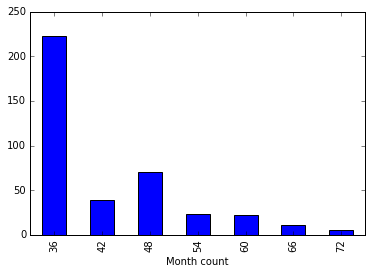

In [124]:
# Distribution of the number of month spent 
bc_sem_count[['Month count']].groupby('Month count').size().plot(kind='bar')

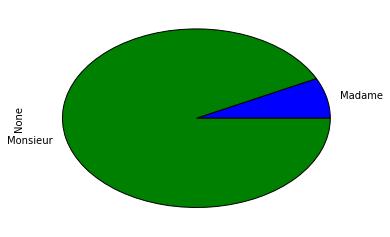

In [125]:
x = bc_sem_count.groupby('Civility').size().plot(kind='pie')

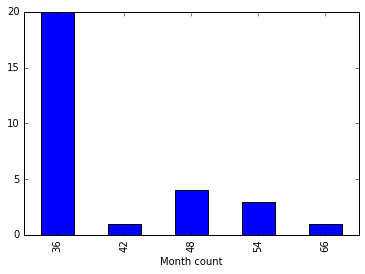

In [126]:
# Distribution for women
bc_sem_count.groupby('Civility').get_group('Madame').groupby('Month count').size().plot(kind='bar')

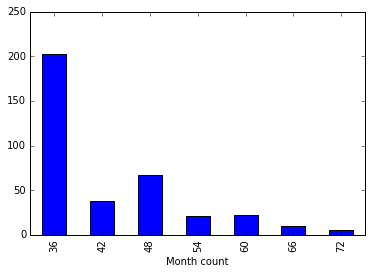

In [127]:
# Distribution for men
bc_sem_count.groupby('Civility').get_group('Monsieur').groupby('Month count').size().plot(kind='bar')

In [128]:
# Compute the average bachelor duration by gender
bc_sem_count.groupby('Civility').mean()

,Month count
Civility,
Madame,40.758621
Monsieur,42.686649


In [129]:
bc_sem_count.groupby('Civility').std()

,Month count
Civility,
Madame,8.078433
Monsieur,9.182272


Finally we have to decide if the difference in the means is statistically significant. To do so we will use the p-value obtained by the Two-Sample T-Test. The p-value represents the probability to observe such a difference even if the two samples are equally distributed. The Two-Sample test assumes that the two data samples are independent which is a reasonable assumption as every student is unique and passes it's exams alone.

In [132]:
# Is the difference statistically significant ?

male = bc_sem_count[bc_sem_count['Civility'] == 'Monsieur']['Month count']
female = bc_sem_count[bc_sem_count['Civility'] == 'Madame']['Month count']

stats.ttest_ind(a= male, b= female, equal_var=False).pvalue
stats.ttest_ind?

With a p-value of ~22% we can see that it is not improbable to observe such a difference in the average bachelor duration if the null hypothesis is that the mean of the two groups are the same.

If we were using a 95% confidence level we would fail to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 5%.

# Exercise 2

Same as before but for the master:

In [ ]:
class MasterPedagogicPeriod(Enum):
    Master1 = 2230106
    Master2 = 942192
    Master3 = 2230128
    #These next three are commented out because there is no data for them.
    #Master4 = 2230140
    #Mineur1 = 2335667
    #Mineur2 = 2335676
    MasterThesisFall = 249127
    MasterThesisSpring = 3781783

Acquire data for Master students. This takes quite some time.

In [ ]:
compiled_data = []

for year in AcademicPeriod:
    for semester in MasterPedagogicPeriod:
        data = parseTable(getDataTable(AcademicUnit.Informatique, year, semester), True)
        data['Year'] = year.name
        data['Semester'] = semester.name
        compiled_data.append(data)
        
master = pd.concat(compiled_data)
master

We are looking for people that have finished their master, or that are finishing it this semester. That is:
* People that are not registered this year
* People that are finishing their master this semester, i.e. people that are in their master thesis    

In [ ]:
master_incomplete = master[(master["Year"] == "y20162017") & (master["Semester"] != "MasterThesisFall")]
master_complete = master[~master["Sciper"].isin(master_incomplete["Sciper"])]

In [ ]:
master_sem_count = master_complete[['Sciper']].copy()
master_sem_count['Month count'] = 6
master_sem_count = master_sem_count.groupby('Sciper').sum()
master_sem_count

#Give them back their civilities
civilities_master = master_complete[['Name', "Sciper", 'Civility']].drop_duplicates()
master_sem_count = civilities_master.join(master_sem_count, how='inner', on='Sciper')
master_sem_count[master_sem_count["Month count"] == 6]